In [21]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import sys
sys.path.append('..') # add the root folder to the path

from diffusion_model import Scheduler, Forwarder, Backwarder, Model, get_mnist_dataset, device

import torch
import matplotlib.pyplot as plt
import matplotlib
from einops import rearrange

FIG_SIZE = 4
matplotlib.rcParams['figure.figsize'] = (FIG_SIZE, FIG_SIZE)

print(f"Using device: {device}")

Using device: cpu


# Plot helper functions

In [23]:
def many_imshow(xs, y_title=None, title=None):
    fig, axes = plt.subplots(1, len(xs), figsize=(FIG_SIZE*len(xs), FIG_SIZE))
    if title is not None:
        fig.suptitle(title)
    if y_title is not None:
        axes[0].set_ylabel(y_title)
    for i, ax in enumerate(axes):
        progress = i / (len(xs)-1)
        ax.imshow(xs[i].cpu(), cmap='gray')
        ax.set_title(f"t={progress*100:.0f}%")
    plt.show()

# Datasets

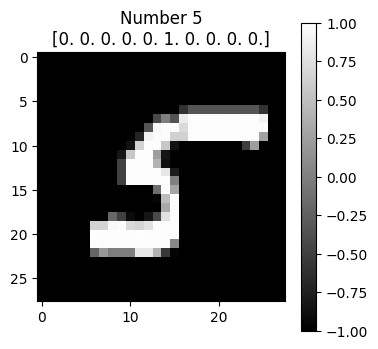

In [24]:
N_SAMPLES = 1000

X, y = get_mnist_dataset()
y_hot = torch.nn.functional.one_hot(y, 10).float().to(device)

idx = torch.randint(0, len(X), (1,))[0]
plt.imshow(X[idx].cpu(), cmap="gray")
plt.title(f"Number {y[idx]}\n{y_hot[idx].cpu().numpy()}")
plt.colorbar();

# Diffusion model

## Scheduler

beta: min=0.009999990463256836, max=0.9990000128746033


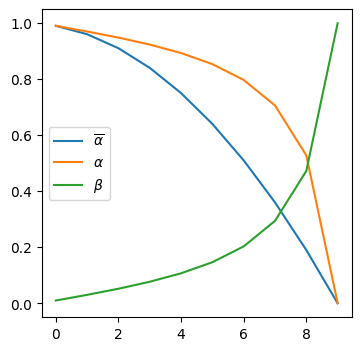

In [25]:
T = 10

sch = Scheduler(n_steps=T, schedule_type="linear-reparam")

plt.plot(sch.alphas_bar.cpu(), label="$\overline{\\alpha}$")
plt.plot(sch.alphas.cpu(), label="$\\alpha$")
plt.plot(sch.betas.cpu(), label="$\\beta$")
plt.legend()

print(f"beta: min={sch.betas.min().item()}, max={sch.betas.max().item()}")

## Forward

Forwarding: 100%|██████████| 9/9 [00:00<00:00, 13802.10it/s]


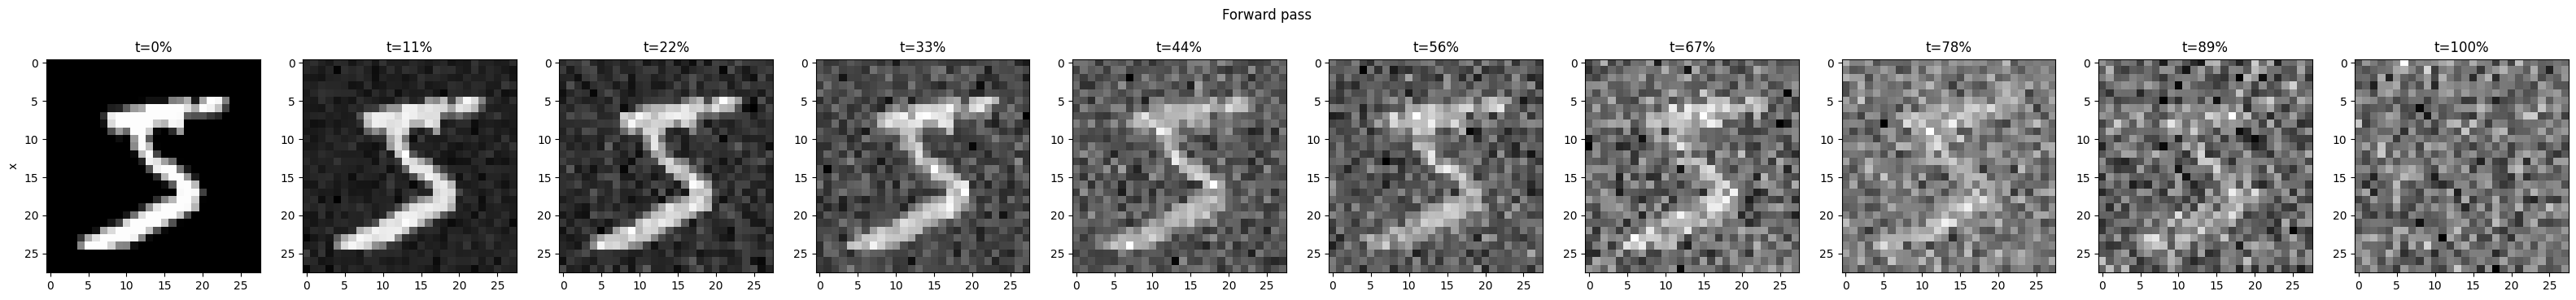

Forwarding: 100%|██████████| 9/9 [00:00<00:00, 11251.49it/s]


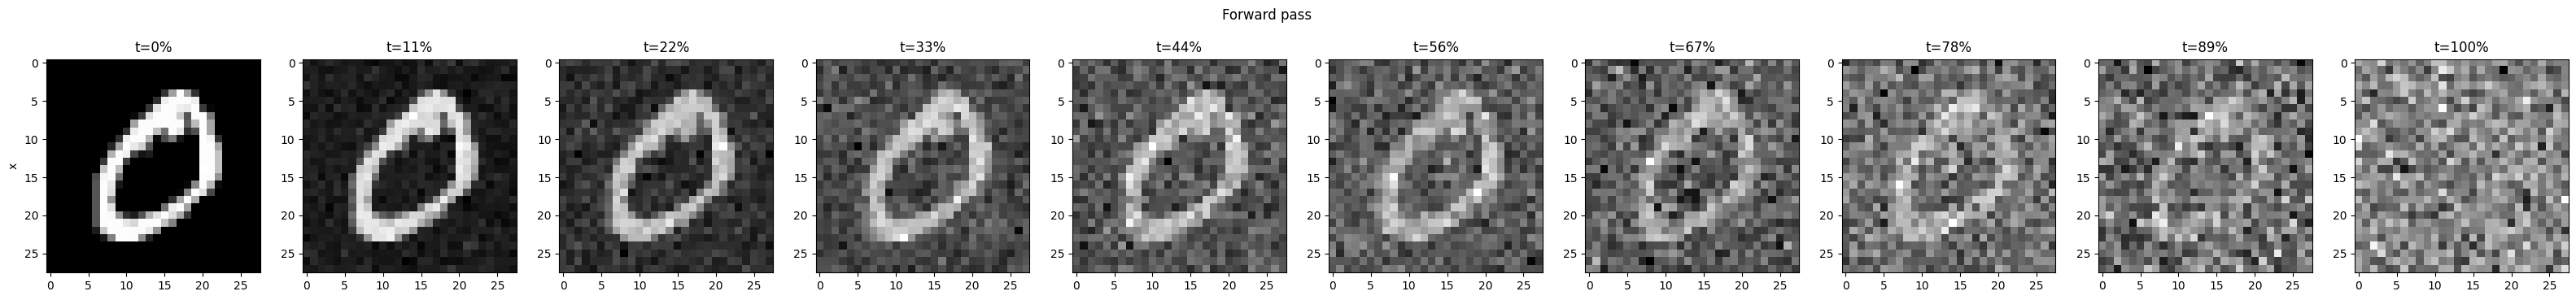

Forwarding: 100%|██████████| 9/9 [00:00<00:00, 13296.49it/s]


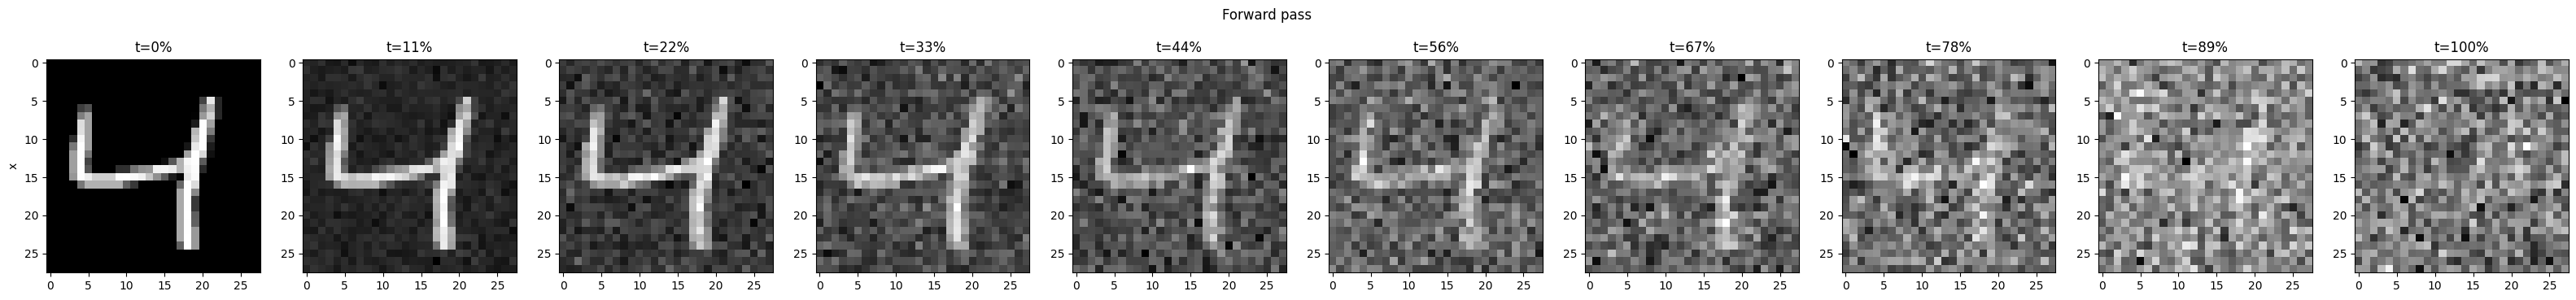

In [26]:
fwd = Forwarder(scheduler=sch)

for x in X[:3]:
    x = x.to(device)
    x_by_t = fwd.forward_loop(x)
    many_imshow(x_by_t, y_title="x", title="Forward pass")

## Backward

In [27]:
model = Model(scheduler=sch, forwarder=fwd)
bkw = Backwarder(scheduler=sch, model=model, sigma="beta")

def plot_backward():
  idx = torch.randint(0, len(X), (1,))[0]
  rand_y = rearrange(y_hot[idx], "d -> 1 d")
  xt = bkw.backward_loop(rand_y, shape=(X.shape[1:]))
  many_imshow(xt, y_title="x", title="Backward pass")

def logger(epoch, loss):
  print(f"Epoch {epoch}: loss={loss.item()}")
  plot_backward()

In [20]:
dataset = torch.utils.data.TensorDataset(X, y_hot)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=256)
model.fit(dataloader, logger=logger, n_epochs=100)

Epoch:   0%|          | 0/100 [00:02<?, ?it/s]


KeyboardInterrupt: 

Backwarding: 100%|██████████| 9/9 [00:00<00:00, 200.28it/s]


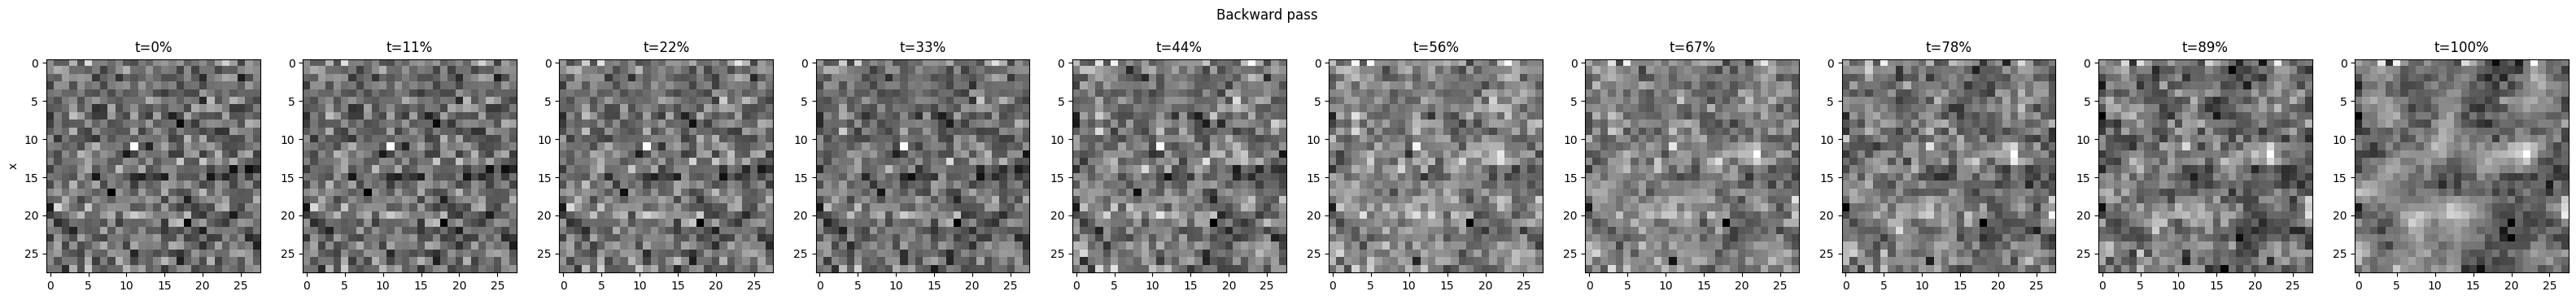

In [18]:
plot_backward()

## Backward

In [ ]:
noise_model = UNetNoiseModel(forward_module, scheduler, label_embedding, time_step_embedding)
backward_module = BackwardModule(forward_module, scheduler, noise_model, "beta")

V19


  0%|          | 0/100 [00:00<?, ?it/s]

loss=0.26043761220384154


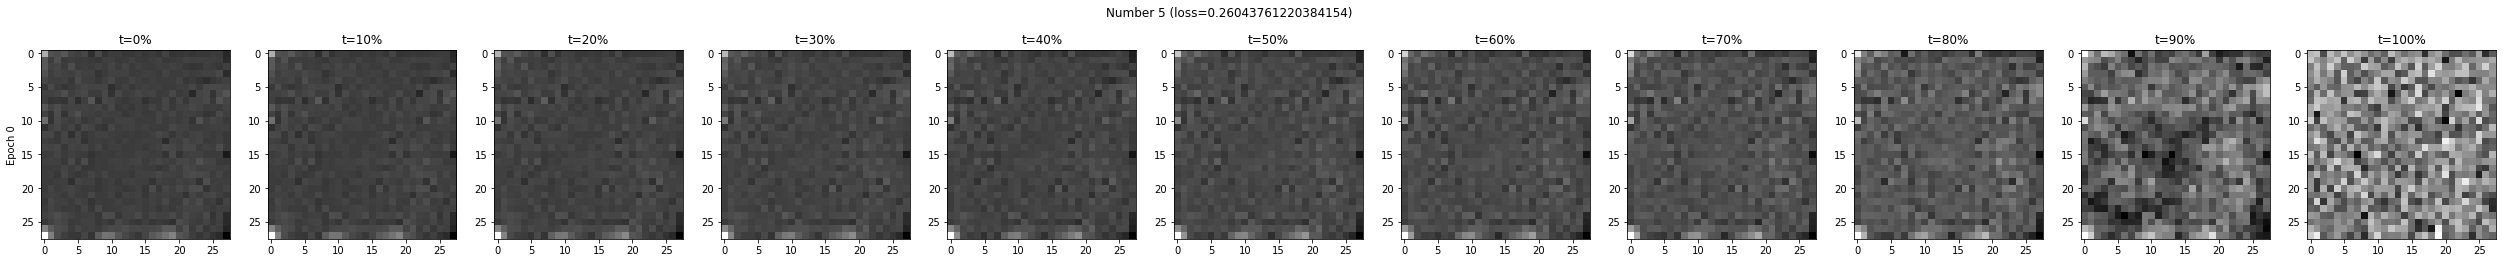

 10%|█         | 10/100 [01:53<16:51, 11.24s/it]

loss=0.06253865958845362


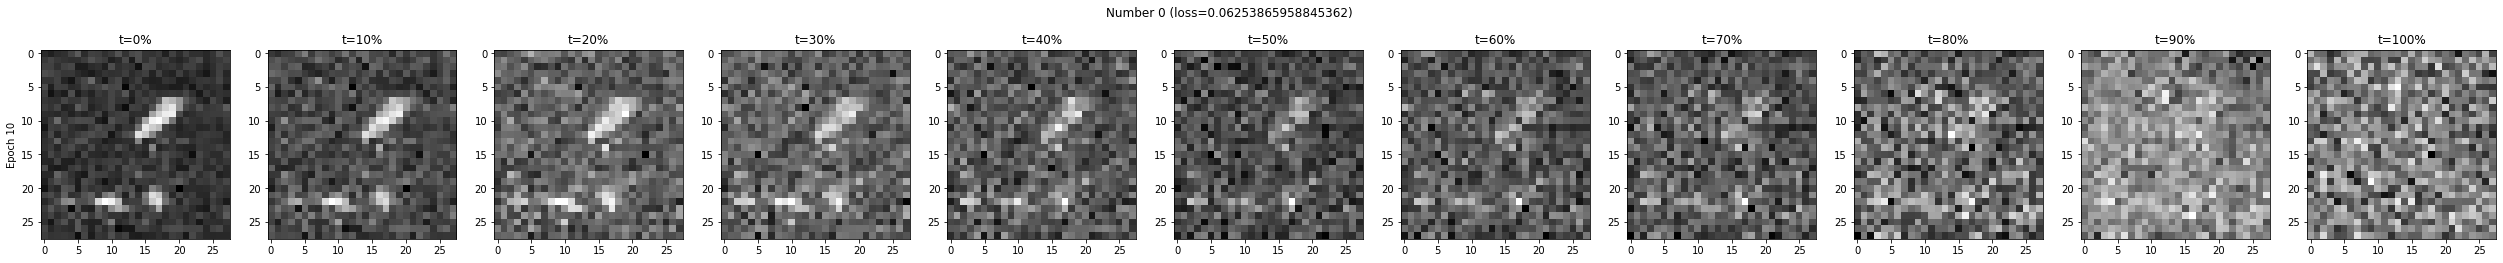

 20%|██        | 20/100 [03:46<14:57, 11.22s/it]

loss=0.056176788740335624


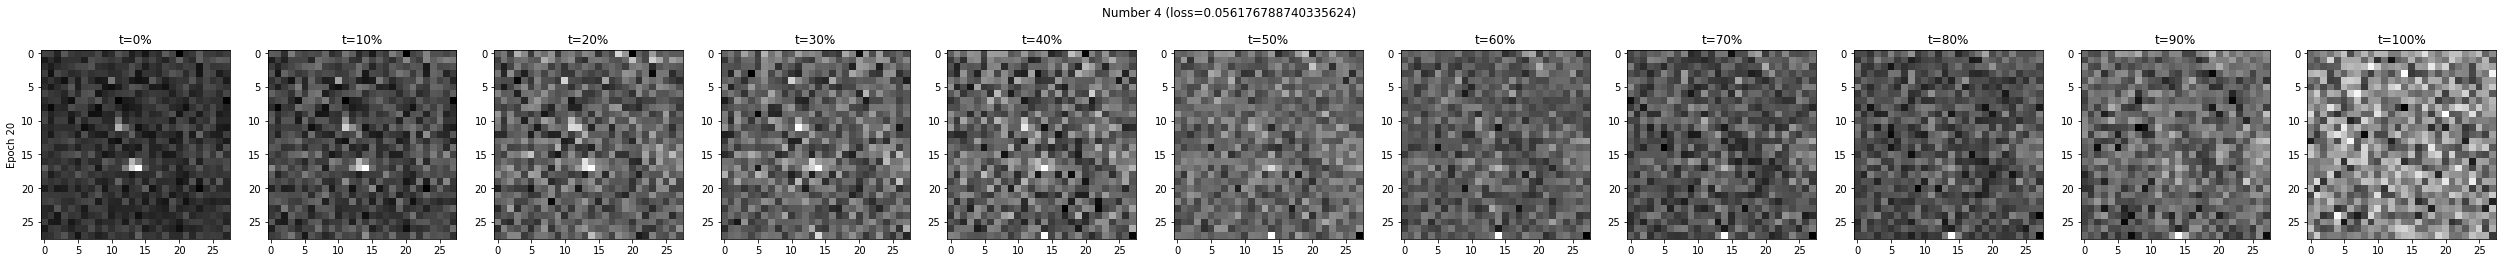

 30%|███       | 30/100 [05:40<13:06, 11.24s/it]

loss=0.05364707180477203


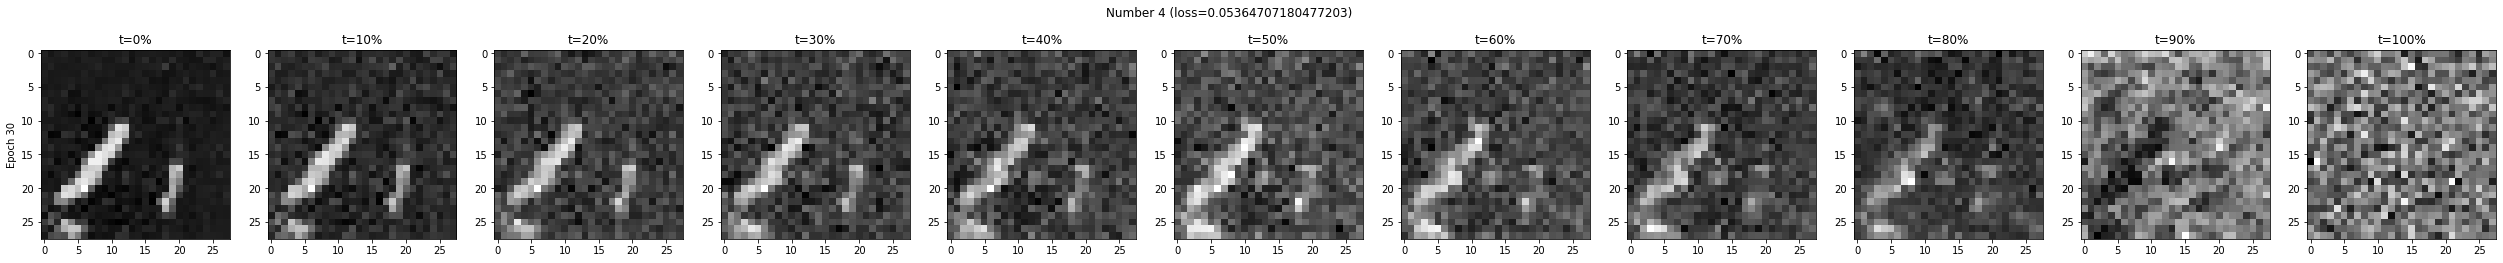

 40%|████      | 40/100 [07:33<11:13, 11.23s/it]

loss=0.05136706147422182


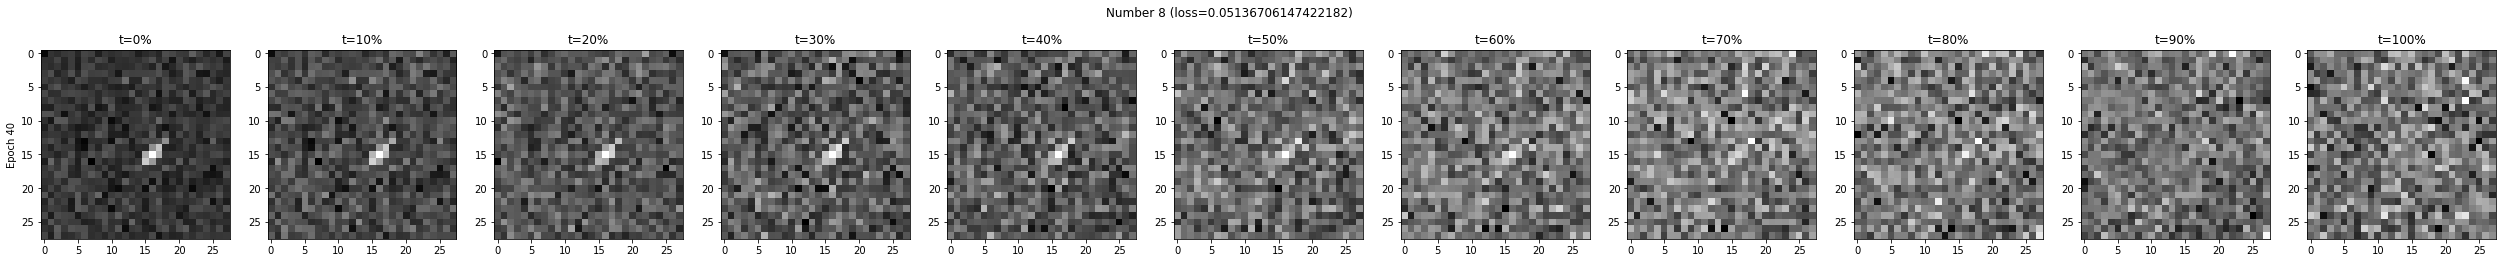

 50%|█████     | 50/100 [09:26<09:21, 11.22s/it]

loss=0.050288243338148644


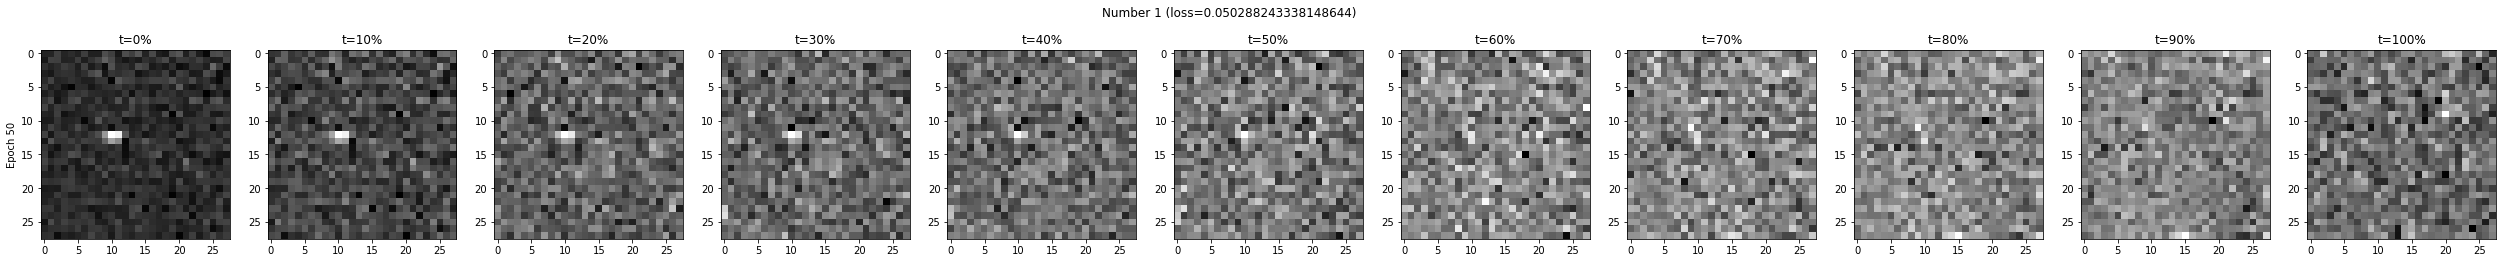

 60%|██████    | 60/100 [11:19<07:28, 11.21s/it]

loss=0.049560256175538324


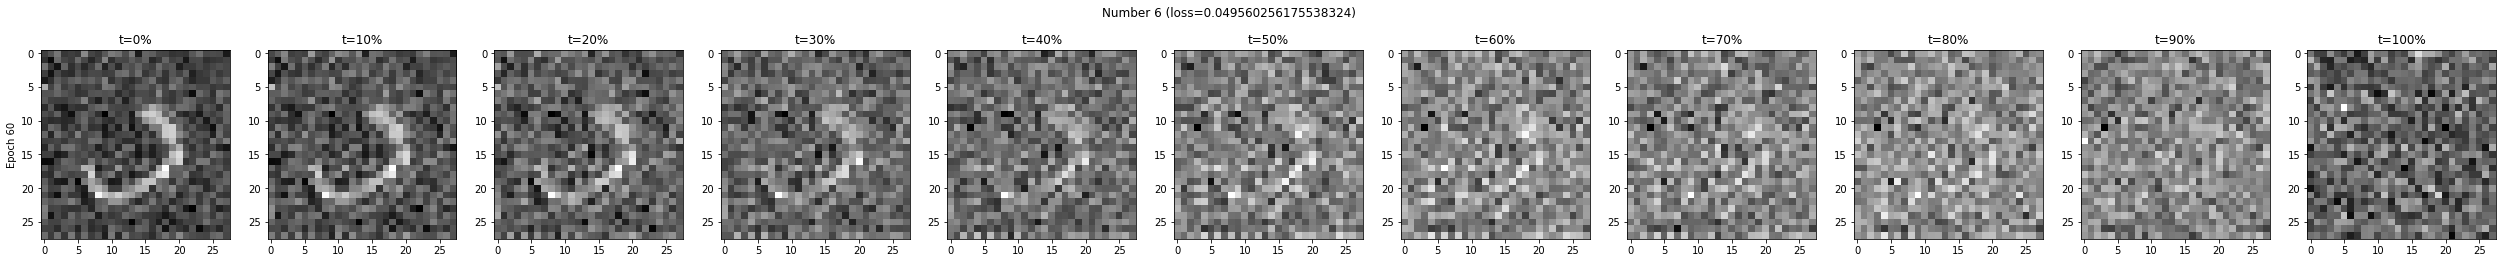

 70%|███████   | 70/100 [13:13<05:36, 11.22s/it]

loss=0.04891379069774709


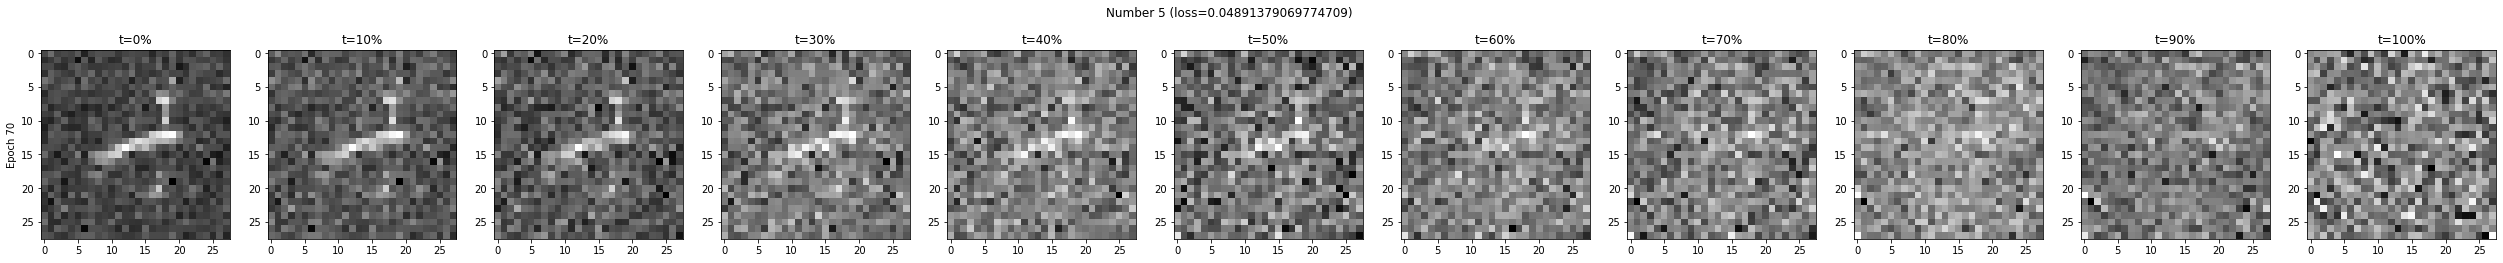

 80%|████████  | 80/100 [15:06<03:44, 11.20s/it]

loss=0.0487239918968779


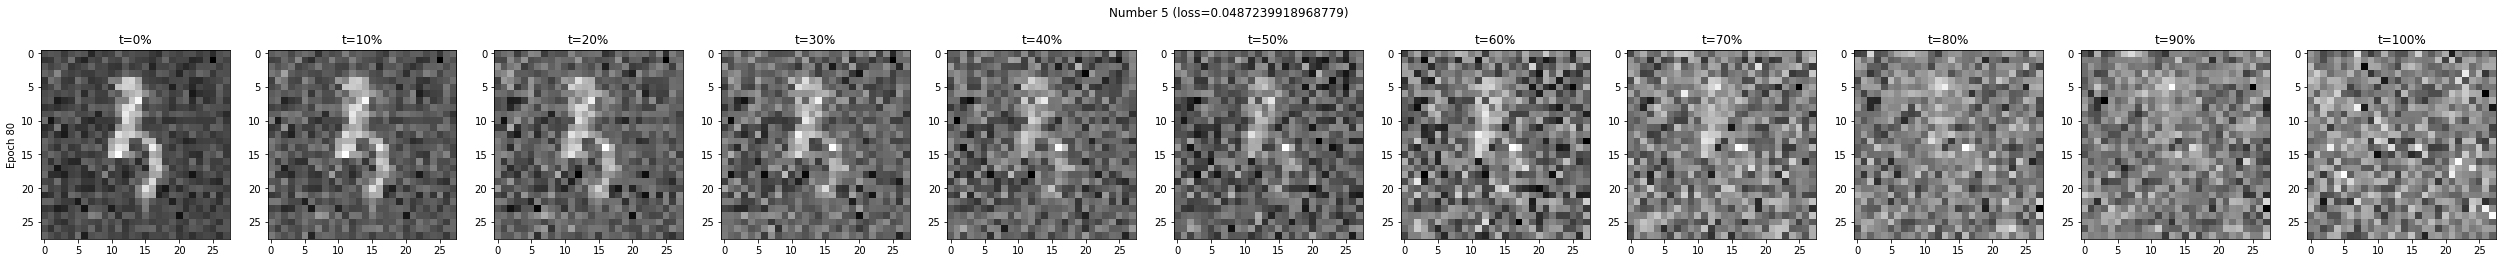

 90%|█████████ | 90/100 [16:59<01:52, 11.20s/it]

loss=0.04813503163292053


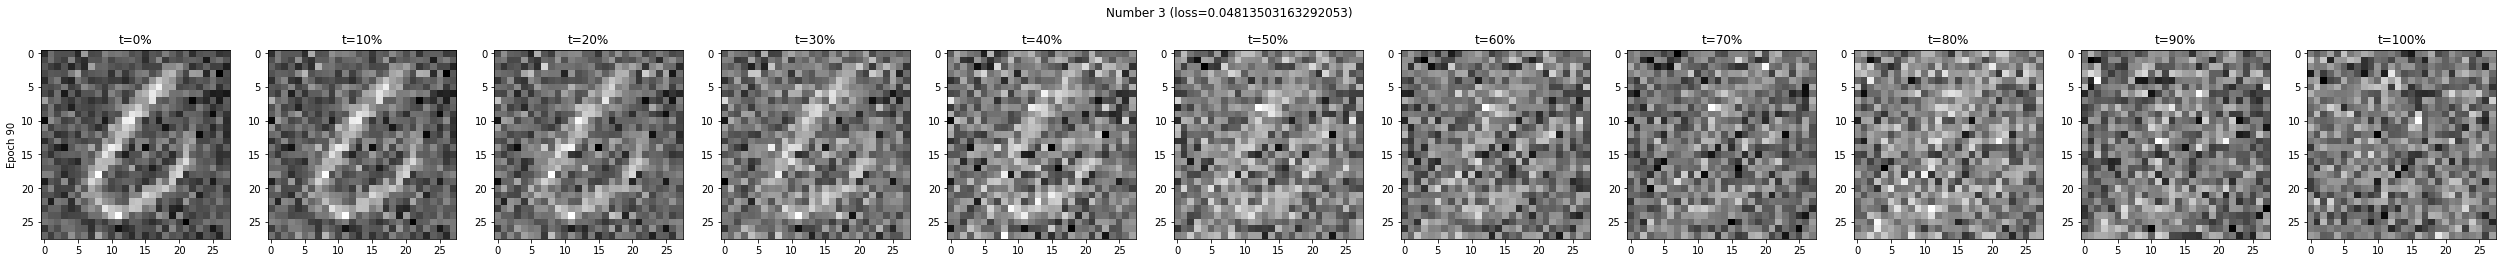

100%|██████████| 100/100 [18:52<00:00, 11.32s/it]


loss=None


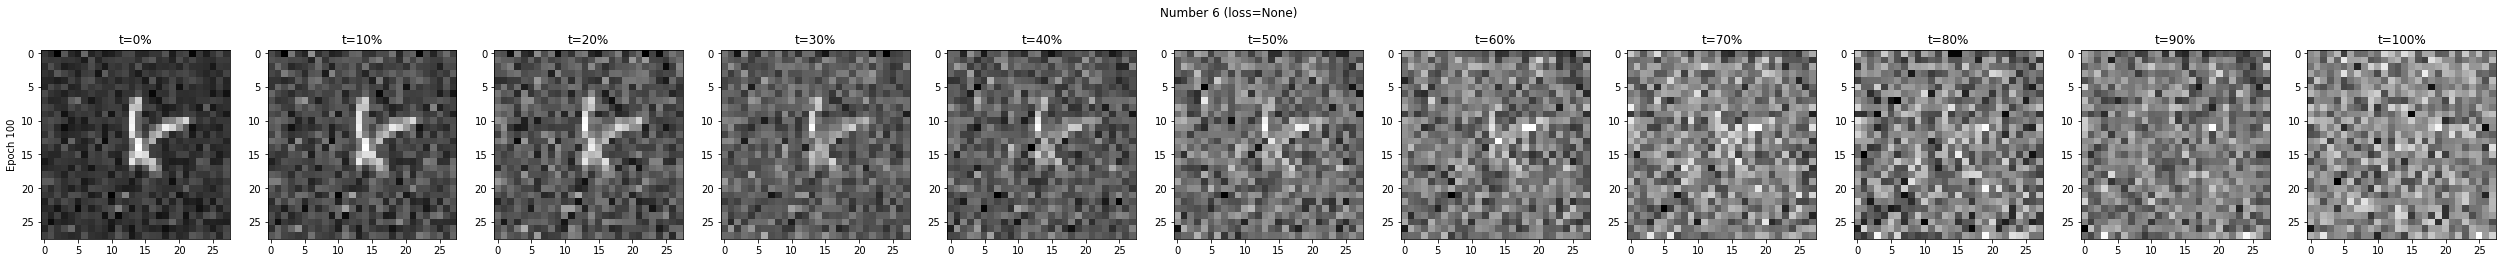

In [ ]:
BATCH_SIZE = 256
NB_EPOCHS = 100

def display_evolutions(epoch, losses=None):
    loss = sum(losses) / len(losses) if losses else None
    label = torch.randint(0, 10, (1,)).to(device)
    with torch.no_grad():
      xs_t = backward_module.loop_backward(label, n_sample=1, nb_displayed_steps=10)
    x_t = rearrange(xs_t, "t 1 h w -> t h w")
    print(f"loss={loss}")
    plot_evolutions(x_t, title=f"Number {label.item()} (loss={loss})", y_title=f"Epoch {epoch}")

X = TensorDataset(dataset, labels)
dataloader = DataLoader(X, batch_size=BATCH_SIZE)
noise_model.fit(dataloader, nb_epochs=NB_EPOCHS, logger=display_evolutions)
display_evolutions(NB_EPOCHS)

In [ ]:
with torch.no_grad():
  display_evolutions(NB_EPOCHS)

# Evaluation

In [ ]:
def check_embedding(base, embedding_model):
    with torch.no_grad():
        base = base.to(device)
        embedded_base = embedding_model(base).detach().cpu()

    n = len(base)
    dist_matrix = torch.zeros((n, n))
    for i in range(n):
        for j in range(n):
            dist_matrix[i, j] = torch.norm(embedded_base[i] - embedded_base[j])
    plt.title("Distance matrix")
    plt.imshow(dist_matrix, cmap='gray')
    plt.colorbar()

check_embedding(torch.eye(10), noise_model.label_embedding)

for i in range(10):
  with torch.no_grad():
    o = noise_model.label_embedding(torch.eye(10)[i].to(device))
    print(o.min().item(), o.mean().item(), o.max().item())

In [ ]:
fig, axes = plt.subplots(2, T+1, figsize=(FIG_SIZE*T, FIG_SIZE*2))

x = rearrange(dataset[0], "h w -> 1 h w")
label = labels[:1]

with torch.no_grad():
    x_t = forward_module.loop_forward(x, nb_displayed_steps=T)
    x_prev = [backward_module.batched_backward(x, t, label) for t, x in enumerate(x_t)]

x_t = rearrange(x_t, "t 1 h w -> t h w")
x_prev = rearrange(x_prev, "t 1 h w -> t h w")
x = rearrange(x, "1 h w -> h w")

axes[0, 0].imshow(x.cpu(), cmap='gray')
axes[1, -1].axis('off')
for i, ax in enumerate(axes[0, 1:]):
    ax.imshow(x_t[i].cpu(), cmap='gray')
for i, ax in enumerate(axes[1,:-1]):
    ax.imshow(x_prev[i].detach().cpu(), cmap='gray')

## Backward

In [ ]:
from einops import repeat

backward_module = BackwardModule(forward_module, scheduler, noise_model, "alpha")

example_labels = torch.arange(0, 10).to(device)
example_labels = repeat(example_labels, "n -> (n 10)")
with torch.no_grad():
  xs = backward_module.loop_backward(example_labels, n_sample=100, nb_displayed_steps=1)[0]
xs = rearrange(xs, "(n b) h w -> b n h w", n=10)

_, axes = plt.subplots(10, 11, figsize=(10*FIG_SIZE, 11*FIG_SIZE))
for i in range(10):
  selected = dataset[labels == i]
  x = sum(selected)/len(selected)
  axes[i,0].imshow(x.cpu(), cmap="gray")
  axes[i,0].set_ylabel(f"Number {i}")
  if i == 0:
    axes[i,0].set_title(f"Mean of real image")
  for j in range(10):
    if i == 0:
      axes[i,j+1].set_title(f"Generation n°{j+1}")
    axes[i,j+1].imshow(xs[j,i], cmap="gray")

In [ ]:
_, axes = plt.subplots(10, 1, figsize=(1*FIG_SIZE, 10*FIG_SIZE))

for i in range(10):
  selected = dataset[labels == i]
  x = sum(selected)/len(selected)
  axes[i].imshow(x.cpu(), cmap="gray")
  axes[i].set_title(f"mean of number {i}")